In [1]:
# default_exp core

# TabNet functionality

> Integrating TabNet with fastai.

In [2]:
#export
from fastai.basics import *
from fastai.tabular.all import *
from pytorch_tabnet.tab_network import TabNetNoEmbeddings

/home/dima/anaconda3/envs/ab/lib/python3.7/site-packages/fastcore/foundation.py:52: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [3]:
#export
from pytorch_tabnet.tab_model import *
from pytorch_tabnet.tab_network import *

class TabNetModel(Module):
    "Attention model for tabular data."
    def __init__(self, emb_szs, n_cont, out_sz, embed_p=0., y_range=None,
                 n_d=8, n_a=8,
                 n_steps=3, gamma=1.3,
                 n_independent=2, n_shared=2, epsilon=1e-15,
                 virtual_batch_size=128, momentum=0.02):
        self.embeds = nn.ModuleList([Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(embed_p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        self.tab_net = TabNetNoEmbeddings(n_emb + n_cont, out_sz, n_d, n_a, n_steps,
                                          gamma, n_independent, n_shared, epsilon, virtual_batch_size, momentum)

    def forward(self, x_cat, x_cont, explain=False):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        preds, m_loss = self.tab_net(x)
        if explain: m_explain, masks = self.tab_net.forward_masks(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(preds) + self.y_range[0]
        if explain:
            return preds, m_loss, m_explain, masks
        else:
            return preds

In [4]:
#exporti
@patch
def size(x:nn.Module, with_grad: bool=True) -> Int:
    return sum(p.numel() for p in x.parameters() if p.requires_grad or not with_grad)

In [5]:
#export
@patch
def explain(x:Learner, dl:TabDataLoader):
    "Get explain values for a set of predictions"
    dec_y = []
    x.model.eval()
    for batch_nb, data in enumerate(dl):
        with torch.no_grad():
            out, M_loss, M_explain, masks = x.model(data[0], data[1], True)
        M_loss, M_explain = map(Tensor.cpu, (M_loss, M_explain))
        for key, value in masks.items():
            masks[key] = csc_matrix.dot(value.cpu().numpy(), emb_reducer)

        explain = csc_matrix.dot(M_explain.numpy(), emb_reducer)
        if batch_nb == 0:
            res_explain = explain
            res_masks = masks
        else:
            res_explain = np.vstack([res_explain, explain])                                     
            for key, value in masks.items():
                res_masks[key] = np.vstack([res_masks[key], value])

        dec_y.append(int(learn.loss_func.decodes(out)))
    return dec_y, res_masks, res_explain

In [6]:
#export
def plot_explain(masks, lbls, figsize=(12,12)):
    "Plots masks with `lbls` (`dls.x_names`)"
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    plt.yticks(np.arange(0, len(masks), 1.0))
    plt.xticks(np.arange(0, len(masks[0]), 1.0))
    ax.set_xticklabels(lbls, rotation=90)
    plt.ylabel('Sample Number')
    plt.xlabel('Variable')
    plt.imshow(masks)

### learn

In [51]:
#export
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
df_main,df_test = df.iloc[:-1000].copy(),df.iloc[-1000:].copy()

#### add random columns to check explain

In [52]:
#add random columns to check explain
df_main['random_float'] = np.random.random_sample(len(df_main))
df_main['random_char'] = np.random.random_sample(len(df_main)).astype(str)

In [53]:
cont_names = df_main.select_dtypes(['int64','float64']).columns.tolist()
cat_names = df_main.select_dtypes('object').columns.tolist()
cat_names.remove('salary')

In [54]:
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df_main))

to = TabularPandas(df_main, procs, cat_names, cont_names, y_names="salary", y_block = CategoryBlock(), splits=splits)
dls = to.dataloaders()
emb_szs = get_emb_sz(to); print(emb_szs)

[(10, 6), (17, 8), (8, 5), (16, 8), (7, 5), (6, 4), (3, 3), (43, 13), (31562, 529), (3, 3)]


In [55]:
model = TabNetModel(emb_szs, len(to.cont_names), dls.c, n_d=8, n_a=32, n_steps=5); 

In [56]:
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

In [67]:
learn.dls.bs

64

In [57]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.568300,0.532386,0.757763,00:34
1,0.457570,0.472130,0.757763,00:38
2,0.460097,0.470912,0.769328,00:38
3,0.436534,0.446949,0.772497,00:37
4,0.440460,0.439892,0.772655,00:37
5,0.391846,0.368632,0.832541,00:35
6,0.300522,0.377390,0.830006,00:40
7,0.180252,0.386435,0.833967,00:54
8,0.099328,0.397545,0.826046,00:40
9,0.070487,0.409926,0.820501,00:37


### explain
> failed to produce good explanation, since random features are found important.

In [58]:
cat_dims = L(emb[1] for emb in emb_szs)
pre_emb = len(to.cont_names) + len(to.cat_names)
post_emb = len(to.cont_names) + cat_dims.sum()
cat_idxs = L(range(len(to.cat_names)))
cat_idxs = list(cat_idxs)

In [59]:
emb_reducer = create_explain_matrix(pre_emb,
                                      cat_dims,
                                      cat_idxs,
                                      post_emb)

In [60]:
len(df_main)

31561

In [74]:
dl = learn.dls.test_dl(df_main.sample(100), bs=1)

In [75]:
dec_y, res_masks, res_explain = learn.explain(dl)

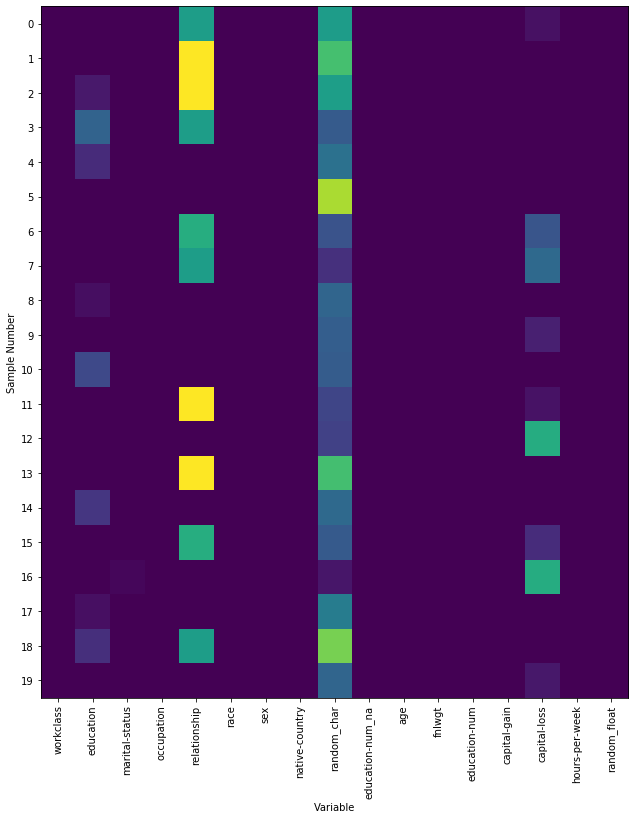

In [76]:
plot_explain(res_explain[:20], dls.x_names)

In [77]:
import plotly.express as px

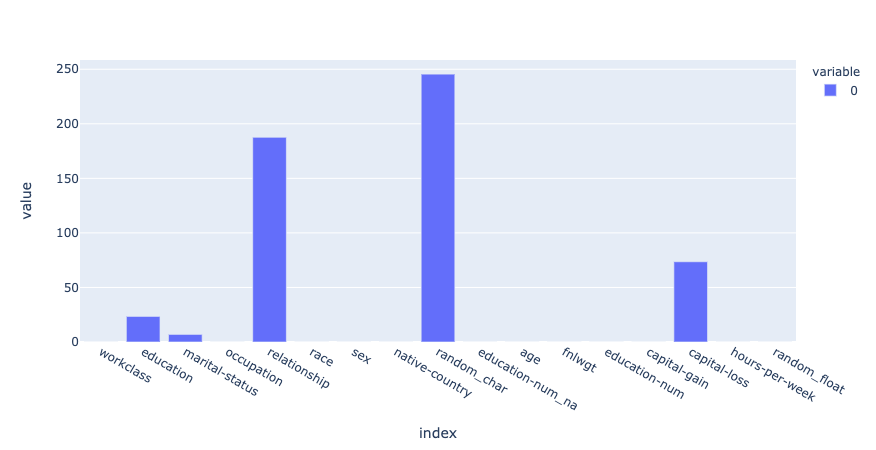

In [78]:
px.bar(pd.DataFrame([res_explain.sum(0)],columns = dls.x_names).T)

In [7]:
#hide
from nbdev.showdoc import *
from nbdev.export import notebook2script
notebook2script() 

Converted 00_core.ipynb.
Converted 01_examples.ipynb.
Converted index.ipynb.
